<h1> <center> Project </center> </h1>

##
### Private information
##

In [1]:
key = '_______'  # Google Geocoder API key
CLIENT_ID = '_______' # my Foursquare ID
CLIENT_SECRET = '_______' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


##
## Part 1. Data acquisition
##

<h5> Let's import all required libraries at first.  </h5>

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import re
import googlemaps
import folium
import json
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import alphashape

gmaps = googlemaps.Client(key=key)


Data

In [20]:
Turin = pd.read_csv('/Coursera Final Project/Turin project/zonal_info.csv')
venues_data = pd.read_csv('/Coursera Final Project/Turin project/venues_data.csv')

#####
<h5> The source of data is Wikipedia page.  </h5>

#####

In [3]:
url = 'https://en.wikipedia.org/wiki/Turin#Administration'
raw_data = requests.get(url).text
soup = bs(raw_data, 'html5lib')


#####
<h5> Data acquisition and creating a dataframe with administrative entites of Turin city.  </h5>

#####

In [4]:

raw_list_of_boroughs = soup.find_all('li')  # Circoscrizione is the same as borough

indexes_with_text = []

for i in range(len(raw_list_of_boroughs)):
    if 'Circoscrizione' in raw_list_of_boroughs[i].text:
        indexes_with_text.append(i)

list_of_boroughs = []
for i in indexes_with_text:
    list_of_boroughs.append(raw_list_of_boroughs[i])

Turin = pd.DataFrame(list_of_boroughs)
for i in range(len(Turin[0])):
    Turin[0][i] = str(Turin[0][i].text)

Turin[['Circoscrizione', 'Zone']] = Turin[0].str.split(':', expand=True)
Turin.drop(0, axis = 1,  inplace = True)
zones = Turin['Zone'].str.split('–', expand = True)
zones.replace({None}, value = False, inplace = True)
Turin = pd.concat([Turin, zones], axis = 1).drop('Zone', axis = 1)


Turin_dict = {'Circoscrizione':[], 'Zone':[]}

for i in range(len(Turin)):
    for k in Turin.columns[1:]:
        Turin_dict['Circoscrizione'].append(Turin.Circoscrizione[i])
        Turin_dict['Zone'].append(Turin[k][i])
    
Turin = pd.DataFrame(Turin_dict)
Turin = Turin[(Turin.Zone != False)].reset_index(drop = True)

C:\Users\39349\anaconda3\lib\site-packages\pandas\core\internals\construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [13]:
Turin.to_csv('/Coursera Final Project/Turin project/administrative_division.csv')
Turin.head()


,Circoscrizione,Zone
0,Circoscrizione 1,Centro
1,Circoscrizione 1,Crocetta
2,Circoscrizione 2,Santa Rita
3,Circoscrizione 2,Mirafiori Nord
4,Circoscrizione 2,Mirafiori Sud


In [18]:
cicro = len(Turin.Circoscrizione.unique())
zones = len(Turin.Zone.unique())

print(f'Overall we have {cicro} boroughs and {zones} zones')

Overall we have 8 boroughs and 34 zones


#####

<h5> Now we need to get locations of acquired zones.  </h5>

#####

In [19]:

lat = []
lng = []

for i in Turin.Zone:
    location_str = f'{i}, Torino Metropolitan City of Turin'
    geocode_result = gmaps.geocode(location_str)
    lat.append(geocode_result[0]['geometry']['location']['lat'])
    lng.append(geocode_result[0]['geometry']['location']['lng'])

#####
<h5> We will add results to 'Turin' dataframe.  </h5>

#####

In [20]:
Turin['Latitude'] = lat
Turin['Longitude'] = lng


#####

<h5> To check whether locations are found without errors, we will visualize them on the map.  </h5>

#####

In [ ]:
# Save dataframe for next usage

# Turin.to_csv('/Coursera Final Project/Turin project/zonal_info.csv')

# Turin = pd.read_csv('/Coursera Final Project/Turin project/zonal_info.csv')


In [43]:
# Location of Turin city.

geocode_result = gmaps.geocode('Turin, Italy')
latitude = geocode_result[0]['geometry']['location']['lat']
longitude = geocode_result[0]['geometry']['location']['lng']

def map_centroids():

    # Create map
    map_Turin = folium.Map(location=[latitude, longitude], width='65%', height='65%', zoom_start=11)

    # 

    for lat, lon, poi in zip(Turin['Latitude'], Turin['Longitude'], Turin['Zone']):
        label = folium.Popup(str(poi), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7).add_to(map_Turin)

    return map_Turin

map_Turin = map_centroids()
map_Turin


# It is possible that map is not shown in Github. I kindly ask you to see figures in my report.

#####

<h5> We are able to explore every zone separately now, so the next step is finding the venues in each zone and select the category of our interest.  </h5>

#####

In [40]:

venues_dict = {'name':[], 'latitude':[], 'longitude':[]}

for zone_index in range(len(Turin.Zone)):
    
    coordinates = str(Turin.Latitude[zone_index]) + ', ' + str(Turin.Longitude[zone_index])

    url = 'https://api.foursquare.com/v2/venues/search'
    params = dict( client_id=CLIENT_ID,
                   client_secret=CLIENT_SECRET,
                   v=VERSION,
                   ll=coordinates,
                   query='pizza',
                   limit=LIMIT, 
                   radius = 1500)
    respone = requests.get(url = url, params = params)
    data = json.loads(respone.text)
    
    venues = data["response"]['venues']
    
    for venue in venues:
        name = venue['name']
        venue_lat = venue['location']['lat']
        venue_lng = venue['location']['lng']
        
        venues_dict['name'].append(name)
        venues_dict['latitude'].append(venue_lat)  
        venues_dict['longitude'].append(venue_lng)


#####

<h5> Congratulations! We have got dataframe with all pizzerias in Turin. Now lets perform some cleaning and then explore this data. </h5>

#####

In [41]:

venues_data = pd.DataFrame(venues_dict)

duplicate_values = venues_data.duplicated(subset=['name', 'latitude', 'longitude']).value_counts()[True]


print(f'Since we put the big radius (1.5 km), we have got {duplicate_values} duplicates \n among {len(venues_data)} values in total\n\n', 
      ' Lets perfom cleaning\n',
      '...........')

print(' ')

venues_data = venues_data[(venues_data.duplicated(subset=['name', 'latitude', 'longitude']) == False)]

print ('The shape of Venues Dataframe is', venues_data.shape)

print('')

venues_data.head()

Since we put the big radius (1.5 km), we have got 533 duplicates 
 among 760 values in total

  Lets perfom cleaning
 ...........
 
The shape of Venues Dataframe is (227, 3)



,name,latitude,longitude
0,Mister Food Pizza,45.075209,7.675397
1,Pizza al taglio,45.076346,7.670114
2,Da Aydin Pizza Kebap Bar (Da Aydın),45.063384,7.677842
3,Ciro Pizza & Birra,45.066536,7.692860
4,Pizza menù,45.072301,7.682812


In [ ]:
# Save dataframe for next usage

# venues_data.to_csv('/Coursera Final Project/Turin project/venues_data.csv')

# venues_data = pd.read_csv('/Coursera Final Project/Turin project/venues_data.csv')

#####

<h5> Perfect, next is the visualization of the venues on the map. We will add it on the same map with zonal centroids. </h5>

#####

In [44]:
map_Turin = map_centroids()

for lat, lon, poi in zip(venues_data['latitude'], venues_data['longitude'], venues_data['name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.Marker([lat, lon],
                  popup=label,
                  icon = folium.Icon(color='green',icon="cutlery", prefix='fa')
                 ).add_to(map_Turin)
    
map_Turin

# It is possible that map is not shown in Github. I kindly ask you to see figures in my report.

#####

I decided  to use density based spatial clustering (especially DBSCAN algorithm), because in this special case K-Means will predict the cluster shape based on predefined number of clusters, however for me is important not the number of clusters and their centroids, but the density of pizzerias in different zones. Indeed, it could be better to open a new business entity in zone with less competition.

The main parameters of DBSCAN are 'eps' and 'min_samples'. 'eps' stands for maximum distance between two samples. 'min_samples' - the number of samples in a neighbourhood for a point to be considered as a core point. The core point definition is based on the principle of DBSCAN algorithm. Basicaly, point is considered as core point if some minimum number of points including itself are in the neighbourhood with this point. Otherwise, if point in neighbourhood with core point, but cannot itself considered as core point, the it will be considered as border point. 

My guess was trivial - I thought that even 2 restaurants  nearby should be considered as cluster, because they already can be considered as competitive business area for my new venue. Well, what is the best 'eps' then? I could be wrong, but I assumed that the best 'eps' will be such distance, when I will have as less as possible outliers of my model, and as high as possible clusters. To find this optimum point I wrote following loop:</h5>


#####

In [45]:

values_to_fit = np.array(list(zip(venues_data.longitude, venues_data.latitude)))

eps_array = np.arange(0.000000001, 0.01, 0.0000010)

outliers = []
for i in tqdm(eps_array):
    db = DBSCAN(eps=i, min_samples=2, n_jobs=-1).fit(values_to_fit)
    outliers.append(np.count_nonzero(db.labels_ == -1))



100%|██████████| 10000/10000 [00:52<00:00, 190.13it/s]


If we will plot now dependency of the ouliers number to maximum distance between pair of points, we will see, that after some elbow point outliers are decreasing so slightly. This elbow point can be considered as best epsilon, since we still have high number of clusters will less outliers. 

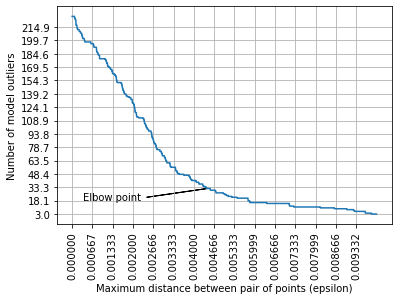

In [48]:
index_arrow = np.where(eps_array == eps_array[(np.round(eps_array, 4) == 0.0045)][0])[0][0]
x_arrow = eps_array[index_arrow]
y_arrow = outliers[index_arrow]
plt.plot(eps_array, outliers)
plt.xlabel('Maximum distance between pair of points (epsilon)')
plt.ylabel('Number of model outliers')
plt.xticks(np.arange(min(eps_array), max(eps_array), step=max(eps_array)/15), rotation = 90)
plt.yticks(np.arange(min(outliers), max(outliers), step=max(outliers)/15))

plt.grid()
plt.arrow(x_arrow-0.002, y_arrow-10, 0.002, 10, width = 0.00001, length_includes_head = True, head_width = None)
plt.text(x = 0.000367, y = 18.1, s = 'Elbow point')
plt.savefig('/Coursera Final Project/Turin project/best_eps.jpeg')




#####

<h5> I rounded epsilon to 0.005 and applied this value to my model. </h5>

#####


In [49]:
values_to_fit = np.array(list(zip(venues_data.longitude, venues_data.latitude)))
db = DBSCAN(eps=0.005, min_samples=2, n_jobs=-1).fit(values_to_fit)
venues_data['clusters'] = db.labels_

#####

<h5> We can color all clusters and show results on the map. </h5>

#####


In [50]:
def map_clusters():

    map_Turin = map_centroids()

    from colour import Color

    colors = []

    for i in range(max(venues_data.clusters.unique())+5):
        colors.append(str(Color(pick_for=i).get_web()))

    index = 0
    for lat, lon, name, cluster in zip(venues_data['latitude'], venues_data['longitude'], venues_data['name'], venues_data['clusters']):
        current_color = colors[cluster]
        label = folium.Popup(str(str(name) + ', ' + str(cluster)), parse_html=True)
        folium.Marker([lat, lon],
                      popup=label,
                      icon = folium.Icon(color= 'white', icon_color=current_color,
                                         icon="cutlery", prefix='fa')
                      ).add_to(map_Turin)
        index +=1

    return map_Turin, colors

map_Turin, colors = map_clusters()
map_Turin


# It is possible that map is not shown in Github. I kindly ask you to see figures in my report.

My idea is based on the density of venues, i.e. on the polygon, or area with other words, which will be served by local pizzerias. What I need - to avoid building up my business in this area. So, now we can plot these areas without pizzerias, however we will include only pizzerias, which were model outliers and did not fall to any cluster. Thus, we can see more or less 'empty' areas. Further analysis of the best place may include some data about empty spaces for rent, demography of the area and criminal data. However, since I am not Italian, it will be difficult for to gather this information without some native with whom I can collaborate. So for now catch this map with free spaces for your new business - _e buon appetito a tutti!_

In [51]:
def map_alpha_shapes():

    map_Turin = map_centroids()
    colors = map_clusters()
    clusters = venues_data[(venues_data.clusters != -1)].clusters.unique()
    
    index = 0

    for cluster in clusters:

        lat_point_list = venues_data[(venues_data.clusters == cluster)].latitude
        lon_point_list = venues_data[(venues_data.clusters == cluster)].longitude

        points = np.array(list(map(list, zip(lon_point_list, lat_point_list))))
        
        # Define alpha parameter
        alpha= 1.5*len(points)

        # Generate the alpha shape
        alpha_shape = alphashape.alphashape(points, alpha)


        folium.GeoJson(alpha_shape).add_to(map_Turin)
        
    venues_data_outliers = venues_data[(venues_data.clusters == -1)]
    
    lat_point_list = venues_data_outliers.latitude
    lon_point_list = venues_data_outliers.longitude    
        
    for lat, lon, name in zip(venues_data_outliers['latitude'], venues_data_outliers['longitude'], venues_data_outliers['name']):
        
        current_color = 'black'
        label = folium.Popup(str(name), parse_html=True)
        folium.Marker([lat, lon],
                      popup=label,
                      icon = folium.Icon(color= 'white', icon_color=current_color,
                                         icon="cutlery", prefix='fa')
                     ).add_to(map_Turin)
        
    

    return map_Turin
    
    
map_Turin = map_alpha_shapes()
map_Turin


# It is possible that map is not shown in Github. I kindly ask you to see figures in my report.


<h1><center>  The End  </center></h1>